# Aktywne uczenie
Olga Krupa, Kinga Kwoka

## Treść zadania

Temat projektu - 10
Aktywne uczenie się modeli klasyfikacji na podstawie małych zbiorów trenujących przez zgłaszanie zapytania o prawdziwe wartości atrybutu docelowego dla ograniczonej liczby przykładów z dostarczonego dużego zbioru danych nieetykietowanych wybranych według określonych kryteriów (np. przykłady bliskie granicy decyzyjnej dotychczasowego modelu lub takie, dla których jego predykcje są obarczone największą niepewnością) i iteracyjne doskonalenie modelu na podstawie powiększanego w ten sposób zbioru trenującego. Implementacja w formie opakowania umożliwiającego użycie dowolnego algorytmu klasyfikacji dostępnego w środowisku R lub Python stosującego standardowy interfejs wywołania. Badanie wpływu użycia aktywnego uczenia się na jakość modeli klasyfikacji tworzonych na podstawie małych zbiorów trenujących za pomocą wybranych algorytmów dostępnych w środowisku R lub Python.

### Środowisko wykonawcze

In [1]:
!pip install modAL-python
!pip install ucimlrepo


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
%%bash
git clone https://github.com/kzkwoka/active_learning_module.git
cd active_learning_module
git checkout dev

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from ucimlrepo import fetch_ucirepo

import matplotlib.pyplot as plt
import math

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification

from src.active import ActiveModule
from src.strategies import *
from src.utils import *

## Cover Type

### Zbiór danych

In [5]:
# fetch dataset
dataset = fetch_ucirepo(id=31) # id=31 (covertype), 144(), 186 (wine quality)

# data (as pandas dataframes)
X = dataset.data.features
y = dataset.data.targets

if dataset.metadata.uci_id == 31:
    _, X, _, y = train_test_split(X, y, test_size=0.1, random_state=42)

n_classes = y.nunique().iloc[0]

### Wstępne przetwarzanie

In [6]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

### Losowy zbiór początkowy

In [8]:
np.random.seed(42)
initial_idx = np.random.randint(low=0, high=X_train.shape[0], size=int(0.1*X_train.shape[0]))

### Ocena na całym zbiorze danych

In [9]:
t = DecisionTreeClassifier(random_state=42)
t.fit(X_train, y_train)
y_pred = t.predict(X_test)

In [10]:
lbin = LabelBinarizer().fit(y_train)
matrix, matrix_pred = lbin.transform(y_test), lbin.transform(y_pred)
benchmark = {
    'default_metric': t.score(X_test, y_test),
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='macro'),
    'recall': recall_score(y_test, y_pred, average='macro'),
    'f1': f1_score(y_test, y_pred, average='macro'),
    'roc_auc': roc_auc_score(matrix, matrix_pred),
    'pr_auc': average_precision_score(matrix, matrix_pred),
    'confusion_matrix': confusion_matrix(y_test, y_pred)
}

In [11]:
{key: round(value,3) for key, value in benchmark.items() if key in ('accuracy', 'roc_auc', 'pr_auc')}

{'accuracy': 0.83, 'roc_auc': 0.855, 'pr_auc': 0.599}

### Aktywne uczenie

In [12]:
learner = ActiveModule(estimator=DecisionTreeClassifier,
                       X=X_train,
                       y_initial=y_train.values[initial_idx],
                       label_idx=initial_idx,
                       X_valid=X_test,
                       y_valid=y_test.values,
                       random_state=42,)

In [13]:
n_samples = 1000
n_iter = math.ceil((X_train.shape[0] - initial_idx.shape[0])/n_samples)

In [14]:
metrics, info = run_experiments(learner, y_train, [random_sampling, uncertainty_sampling, ], n_samples, n_iter)  #1min 14s  kmeans_plus_plus_sampling

100%|██████████| 2/2 [00:22<00:00, 11.30s/it]


In [16]:
for i in info:
    print(i)

One training loop with <function random_sampling at 0x75a830617c70> takes approx. 0.27s
One training loop with <function uncertainty_sampling at 0x75a7d87c6a70> takes approx. 0.27s


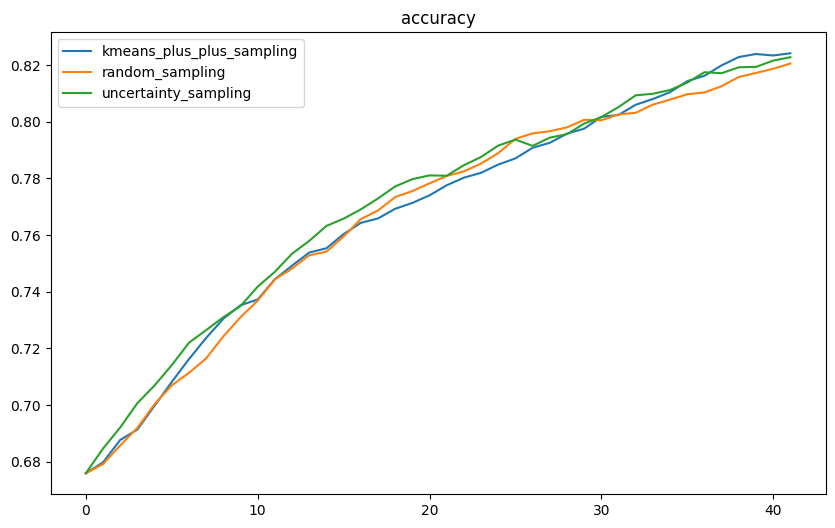

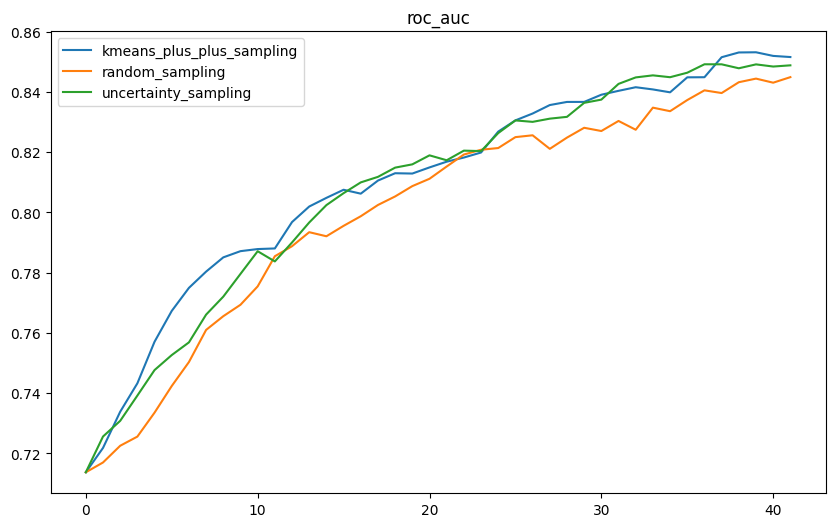

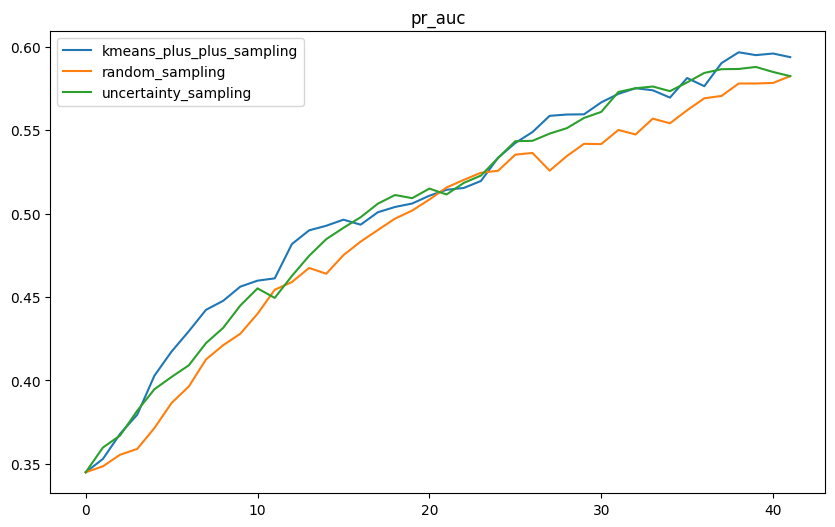

In [18]:
for metric in ["accuracy", "roc_auc", "pr_auc"]:
    fig, ax = plt.subplots(figsize=(10, 6))
    for strategy, df in metrics.groupby('strategy'):
        ax.plot(df.index.get_level_values(1), smooth(df[metric],0.6), label=f'{strategy}')
    plt.legend()
    plt.title(metric)
    plt.show()

### Aktywne uczenie z biblioteką modAL

In [20]:
import modAL
from modAL.models import ActiveLearner

In [37]:
mlearner = ActiveLearner(
    estimator=DecisionTreeClassifier(random_state=42),
    query_strategy=modAL.uncertainty.uncertainty_sampling,
    X_training=X_train[initial_idx], y_training=y_train.values[initial_idx]
)
X_to_train = X_train.copy()
y_to_train = y_train.values.copy()
modAL_metrics = []

query_idx = initial_idx

for i in (t:= tqdm(range(n_iter))):
    mlearner.teach(X_to_train[query_idx], y_to_train[query_idx])
    
    X_to_train = np.delete(X_to_train, query_idx, axis=0)
    y_to_train = np.delete(y_to_train, query_idx, axis=0)
    y_pred = mlearner.predict(X_test)
    matrix, matrix_pred = lbin.transform(y_test), lbin.transform(y_pred)
    modAL_metrics.append({
        'default_metric': mlearner.score(X_test, y_test),
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro'),
        'recall': recall_score(y_test, y_pred, average='macro'),
        'f1': f1_score(y_test, y_pred, average='macro'),
        'roc_auc': roc_auc_score(matrix, matrix_pred),
        'pr_auc': average_precision_score(matrix, matrix_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    })
    query_idx, query_inst = mlearner.query(X_to_train, n_instances=n_samples)

avg_loop_time = t.format_dict['elapsed']/ t.format_dict['total']  
modAL_metrics = pd.DataFrame(modAL_metrics)
# modAL_metrics[["accuracy", "pr_auc", "roc_auc"]].plot()
# print(learner.score(X_test, y_test))

100%|██████████| 42/42 [00:13<00:00,  3.16it/s]


In [43]:
f"One training loop with uncertainty_sampling from modAL takes approx. {round(avg_loop_time, 2)}s"

'One training loop with uncertainty_sampling from modAL takes approx. 0.32s'

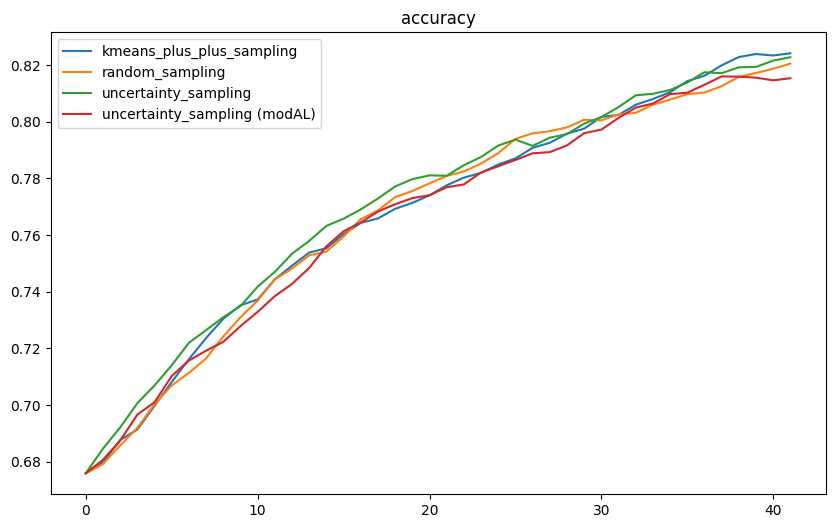

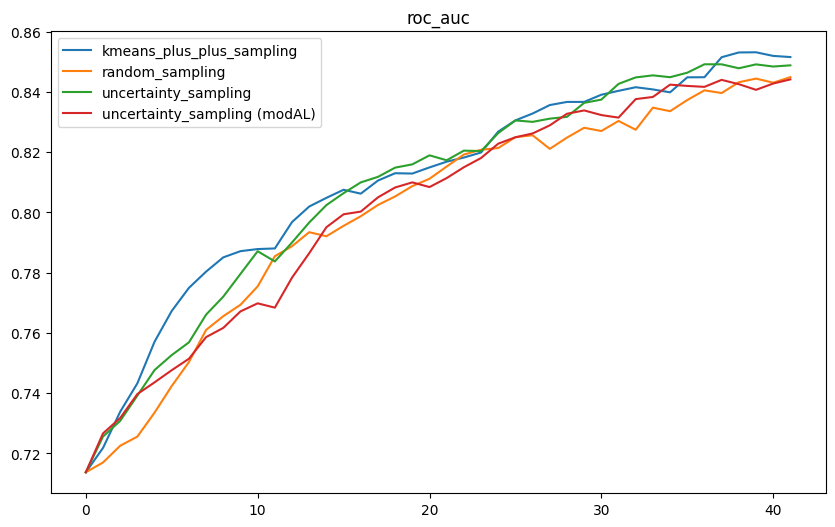

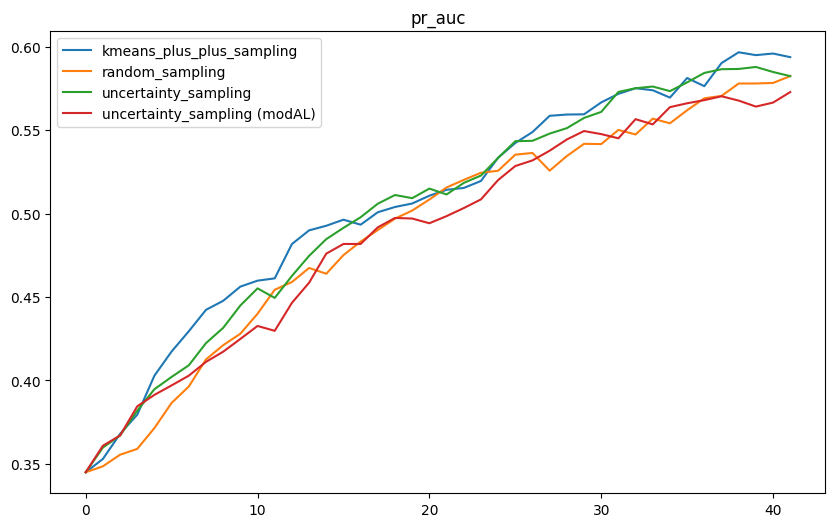

In [27]:
for metric in ["accuracy", "roc_auc", "pr_auc"]:
    fig, ax = plt.subplots(figsize=(10, 6))
    for strategy, df in metrics.groupby('strategy'):
        ax.plot(df.index.get_level_values(1), smooth(df[metric],0.6), label=f'{strategy}')
    ax.plot(modAL_metrics.index, smooth(modAL_metrics[metric], 0.6), label=f'uncertainty_sampling (modAL)')
    plt.legend()
    plt.title(metric)
    plt.show()

## Wine quality

### Zbiór danych

In [ ]:
# fetch dataset
dataset = fetch_ucirepo(id=186) # id=31 (covertype), 144(), 186 (wine quality)

# data (as pandas dataframes)
X = dataset.data.features
y = dataset.data.targets

if dataset.metadata.uci_id == 31:
    _, X, _, y = train_test_split(X, y, test_size=0.1, random_state=42)

n_classes = y.nunique().iloc[0]

### Wstępne przetwarzanie

In [ ]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

### Losowy zbiór początkowy

In [ ]:
np.random.seed(42)
initial_idx = np.random.randint(low=0, high=X_train.shape[0], size=int(0.1*X_train.shape[0]))

### Ocena na całym zbiorze danych

In [ ]:
t = KNeighborsClassifier(n_neighbors=n_classes)
t.fit(X_train, y_train)
y_pred = t.predict(X_test)

In [ ]:
lbin = LabelBinarizer().fit(y_train)
matrix, matrix_pred = lbin.transform(y_test), lbin.transform(y_pred)
benchmark = {
    'default_metric': t.score(X_test, y_test),
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='macro'),
    'recall': recall_score(y_test, y_pred, average='macro'),
    'f1': f1_score(y_test, y_pred, average='macro'),
    'roc_auc': roc_auc_score(matrix, matrix_pred),
    'pr_auc': average_precision_score(matrix, matrix_pred),
    'confusion_matrix': confusion_matrix(y_test, y_pred)
}

In [ ]:
{key: round(value,3) for key, value in benchmark.items() if key in ('accuracy', 'roc_auc', 'pr_auc')}

{'accuracy': 0.568, 'roc_auc': 0.582, 'pr_auc': 0.206}

### Aktywne uczenie

In [ ]:
learner = ActiveModule(estimator=KNeighborsClassifier,
                       X=X_train,
                       y_initial=y_train.values[initial_idx],
                       label_idx=initial_idx,
                       X_valid=X_test,
                       y_valid=y_test.values,
                       n_neighbors=n_classes,)

In [ ]:
n_samples = 100
n_iter = math.ceil((X_train.shape[0] - initial_idx.shape[0])/n_samples)

In [ ]:
metrics, info = run_experiments(learner, y_train, [random_sampling, uncertainty_sampling, kmeans_plus_plus_sampling,], n_samples, n_iter)  #14 min  diversity_sampling

100%|██████████| 4/4 [15:16<00:00, 229.03s/it]


In [ ]:
for i in info:
    print(i)

One training loop with random_sampling takes approx. 0.3s
One training loop with uncertainty_sampling takes approx. 0.43s
One training loop with kmeans_plus_plus_sampling takes approx. 0.34s
One training loop with diversity_sampling takes approx. 18.42s


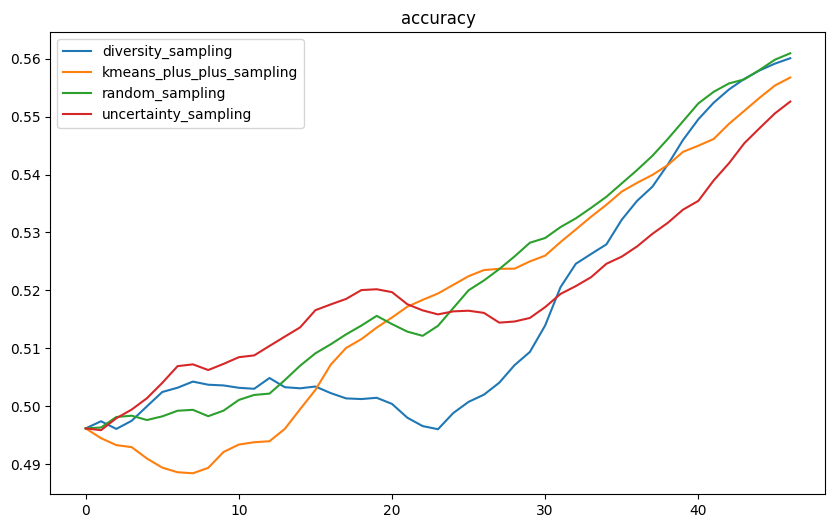

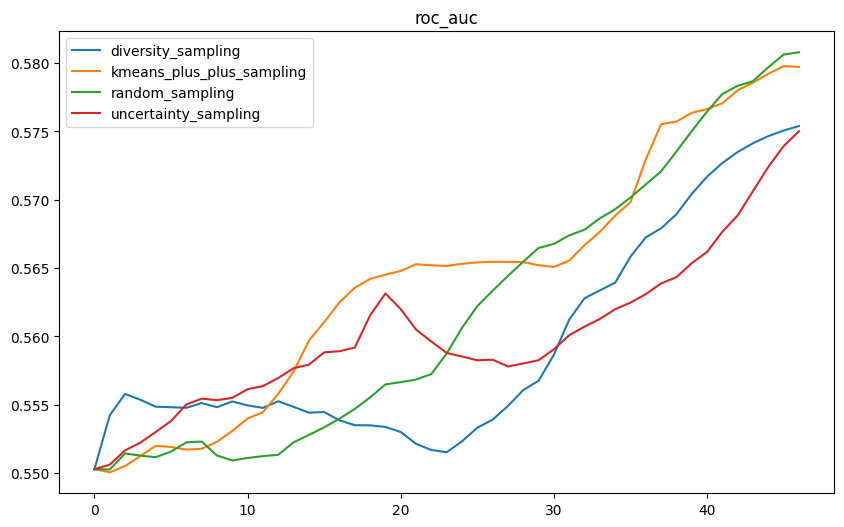

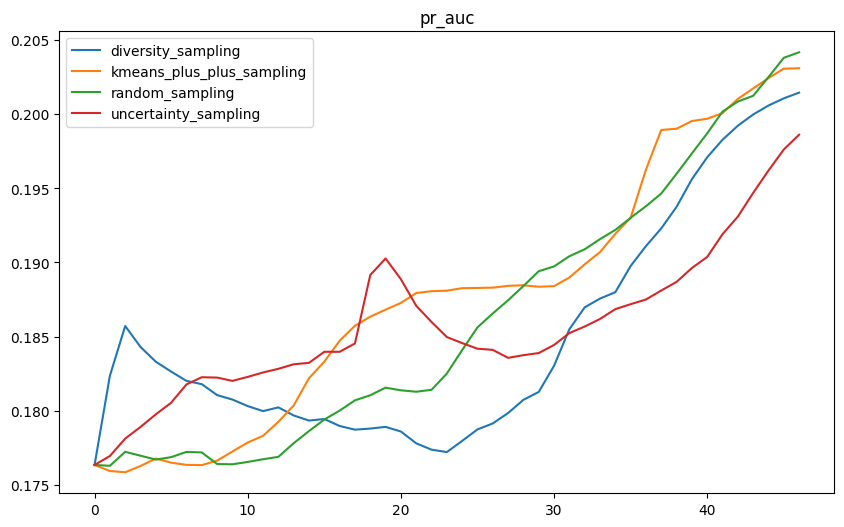

In [ ]:
for metric in ["accuracy", "roc_auc", "pr_auc"]:
    fig, ax = plt.subplots(figsize=(10, 6))
    for strategy, df in metrics.groupby('strategy'):
        ax.plot(df.index.get_level_values(1), smooth(df[metric],0.8), label=f'{strategy}')
    plt.legend()
    plt.title(metric)
    plt.show()

### Aktywne uczenie z biblioteką modAL

In [ ]:
import modAL
from modAL.models import ActiveLearner

In [ ]:
mlearner = ActiveLearner(
    estimator=KNeighborsClassifier(n_neighbors=n_classes),
    query_strategy=modAL.uncertainty.uncertainty_sampling,
    X_training=X_train[initial_idx], y_training=y_train.values[initial_idx]
)
X_to_train = X_train.copy()
y_to_train = y_train.values.copy()
modAL_metrics = []

query_idx = initial_idx

for i in (t:= tqdm(range(n_iter))):
    mlearner.teach(X_to_train[query_idx], y_to_train[query_idx])
    
    X_to_train = np.delete(X_to_train, query_idx, axis=0)
    y_to_train = np.delete(y_to_train, query_idx, axis=0)
    y_pred = mlearner.predict(X_test)
    matrix, matrix_pred = lbin.transform(y_test), lbin.transform(y_pred)
    modAL_metrics.append({
        'default_metric': mlearner.score(X_test, y_test),
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro'),
        'recall': recall_score(y_test, y_pred, average='macro'),
        'f1': f1_score(y_test, y_pred, average='macro'),
        'roc_auc': roc_auc_score(matrix, matrix_pred),
        'pr_auc': average_precision_score(matrix, matrix_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    })
    query_idx, query_inst = mlearner.query(X_to_train, n_instances=n_samples)

avg_loop_time = t.format_dict['elapsed']/ t.format_dict['total']  
modAL_metrics = pd.DataFrame(modAL_metrics)
# modAL_metrics[["accuracy", "pr_auc", "roc_auc"]].plot()
# print(learner.score(X_test, y_test))

100%|██████████| 47/47 [00:19<00:00,  2.41it/s]


In [ ]:
f"One training loop with uncertainty_sampling from modAL takes approx. {round(avg_loop_time, 2)}s"

'One training loop with uncertainty_sampling from modAL takes approx. 0.41s'

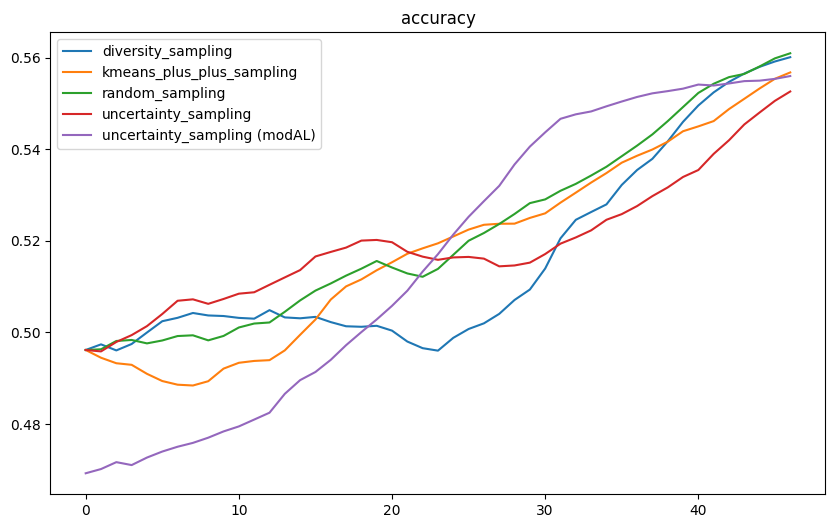

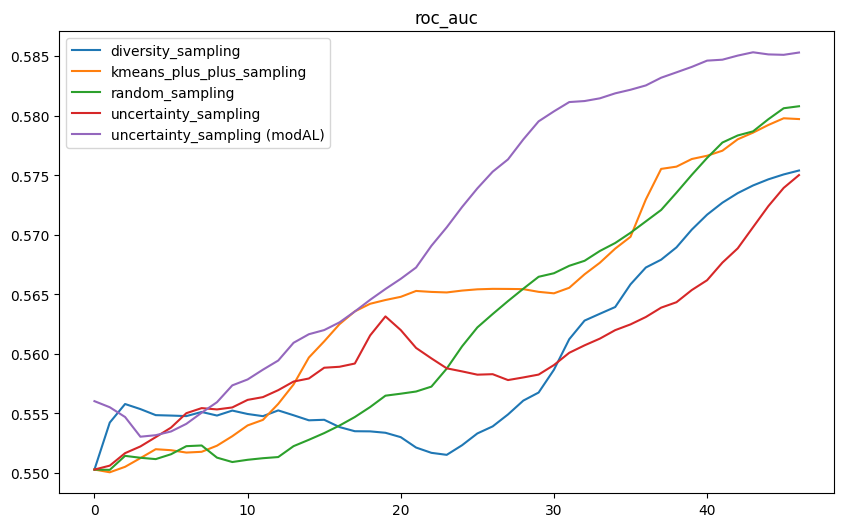

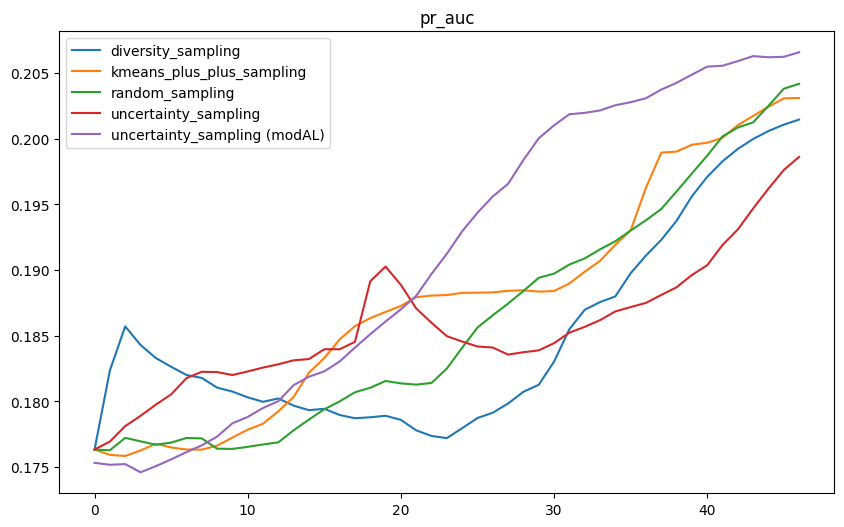

In [ ]:
for metric in ["accuracy", "roc_auc", "pr_auc"]:
    fig, ax = plt.subplots(figsize=(10, 6))
    for strategy, df in metrics.groupby('strategy'):
        ax.plot(df.index.get_level_values(1), smooth(df[metric],0.8), label=f'{strategy}')
    ax.plot(modAL_metrics.index, smooth(modAL_metrics[metric], 0.8), label=f'uncertainty_sampling (modAL)')
    plt.legend()
    plt.title(metric)
    plt.show()

## Syntetyczny (sklearn.datasets.make_classification)

### Zbiór danych

In [ ]:
X,y = make_classification(
    n_samples=5000,
    n_features=10,
    n_informative=6,
    n_classes=4,
    weights=[0.3,0.1,0.5,0.1],
    n_clusters_per_class=1,
    class_sep=1,
    hypercube=True,
    random_state=42)

In [ ]:
from sklearn.decomposition import PCA

df = pd.DataFrame(X)
pcom = PCA(n_components=2).fit_transform(df)

In [ ]:
df = pd.concat([pd.DataFrame(pcom),pd.Series(y)], axis=1)
df.columns = ["X","Y","color"]
df.plot(kind='scatter', x="X",y="Y", color=df["color"], colormap='viridis')

### Wstępne przetwarzanie

In [ ]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

### Losowy zbiór początkowy

In [ ]:
np.random.seed(42)
initial_idx = np.random.randint(low=0, high=X_train.shape[0], size=int(0.1*X_train.shape[0]))

### Ocena na całym zbiorze danych

In [ ]:
t = SVC(probability=True, random_state=42)
t.fit(X_train, y_train)
y_pred = t.predict(X_test)

In [ ]:
lbin = LabelBinarizer().fit(y_train)
matrix, matrix_pred = lbin.transform(y_test), lbin.transform(y_pred)
benchmark = {
    'default_metric': t.score(X_test, y_test),
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='macro'),
    'recall': recall_score(y_test, y_pred, average='macro'),
    'f1': f1_score(y_test, y_pred, average='macro'),
    'roc_auc': roc_auc_score(matrix, matrix_pred),
    'pr_auc': average_precision_score(matrix, matrix_pred),
    'confusion_matrix': confusion_matrix(y_test, y_pred)
}

In [ ]:
{key: round(value,3) for key, value in benchmark.items() if key in ('accuracy', 'roc_auc', 'pr_auc')}

### Aktywne uczenie

In [ ]:
learner = ActiveModule(estimator=SVC,
                       X=X_train,
                       y_initial=y_train[initial_idx],
                       label_idx=initial_idx,
                       X_valid=X_test,
                       y_valid=y_test,
                       probability=True,
                       random_state=42)

In [ ]:
n_samples = 500
n_iter = math.ceil((X_train.shape[0] - initial_idx.shape[0])/n_samples)

In [ ]:
metrics, info = run_experiments(learner, y_train, [random_sampling, uncertainty_sampling, kmeans_plus_plus_sampling], n_samples, n_iter)

In [ ]:
for i in info:
    print(i)

In [ ]:
for metric in ["accuracy", "roc_auc", "pr_auc"]:
    fig, ax = plt.subplots(figsize=(10, 6))
    for strategy, df in metrics.groupby('strategy'):
        ax.plot(df.index.get_level_values(1), smooth(df[metric],0.1), label=f'{strategy}')
    plt.legend()
    plt.title(metric)
    plt.show()